# Data Preprocessing and Exploratory Data Analysis

## 1. Introduction
**Objective:** Load, clean, and analyze historical financial data for Tesla (TSLA), Vanguard Total Bond Market ETF (BND), and S&P 500 ETF (SPY) to prepare for forecasting and portfolio optimization.

**Context:**
*   **TSLA:** High growth, high volatility (Consumer Discretionary).
*   **BND:** Stability, low risk (Bonds).
*   **SPY:** Market benchmark, moderate risk (Equities).

## 2. Setup and Imports
Importing standard libraries and our custom modules from `src`.

In [10]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Add the project root to the path so we can import from src
sys.path.append(os.path.abspath(os.path.join('..')))

from src.loader import DataLoader
from src.preprocessing import clean_data, get_adj_close, calculate_returns
from src.eda import plot_closing_prices, plot_daily_returns, plot_rolling_stats, check_stationarity, decompose_series, calculate_risk_metrics

## 3. Data Extraction
We fetch data from **Jan 1, 2015** to **Jan 15, 2026** (as per current date context).

In [2]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

loader = DataLoader(start_date, end_date)
raw_data = loader.fetch_data(tickers)

# Display the first few rows to understand structure
raw_data.head()

Fetching data for ['TSLA', 'BND', 'SPY'] from 2015-01-01 to 2026-01-15...


[*********************100%***********************]  3 of 3 completed

Data successfully fetched from API.


Ticker           TSLA                                                   BND  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2015-01-02  14.858000  14.883333  14.217333  14.620667  71466000  60.225229   
2015-01-05  14.303333  14.433333  13.810667  14.006000  80527500  60.451750   
2015-01-06  14.004000  14.280000  13.614000  14.085333  93928500  60.663591   
2015-01-07  14.223333  14.318667  13.985333  14.063333  44526000  60.743979   
2015-01-08  14.187333  14.253333  14.000667  14.041333  51637500  60.722039   

Ticker                                                       SPY              \
Price            High        Low      Close   Volume        Open        High   
Date                                                                           
2015-01-02  60.415193  60.217922  60.385967  2218800  171.378492  171.793694   
2015-01-05  60.583262  60.422524  60.561344  5820100  169.543288  169.709366   
2015-01-06  60.919308  60.663591  60.736652  3887600  167.816050  168.339208   
2015-01-07  60.846266  60.678226  60.773205  2433400  167.259691  168.339217   
2015-01-08  60.722039  60.619752  60.678204  1873400  169.410459  171.195832   

Ticker                                         
Price              Low       Close     Volume  
Date                                           
2015-01-02  169.551596  170.589600  121465900  
2015-01-05  167.201559  167.508804  169632600  
2015-01-06  165.133853  165.931046  209151400  
2015-01-07  166.811279  167.998749  125346700  
2015-01-08  169.393860  170.979919  147217800

## 4. Data Cleaning
We perform the following checks:
1.  Check for missing values (fill or drop).
2.  Verify data types.
3.  Extract `Adj Close` specifically for analysis.

In [3]:
# Clean the raw data (handle NaNs)
cleaned_data = clean_data(raw_data)

# Extract Adjusted Close prices for the 3 assets
adj_close_df = get_adj_close(cleaned_data, tickers)
adj_close_df.head()

Checking for missing values...
No missing values found.
Note: 'Adj Close' not found for TSLA. Using 'Close' (likely already adjusted).
Note: 'Adj Close' not found for BND. Using 'Close' (likely already adjusted).
Note: 'Adj Close' not found for SPY. Using 'Close' (likely already adjusted).


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,60.385967,170.589600
2015-01-05,14.006000,60.561344,167.508804
2015-01-06,14.085333,60.736652,165.931046
2015-01-07,14.063333,60.773205,167.998749
2015-01-08,14.041333,60.678204,170.979919


## 5. Exploratory Data Analysis (EDA)

### 5.1 Historical Closing Prices
Visualizing the price trend over the last decade.

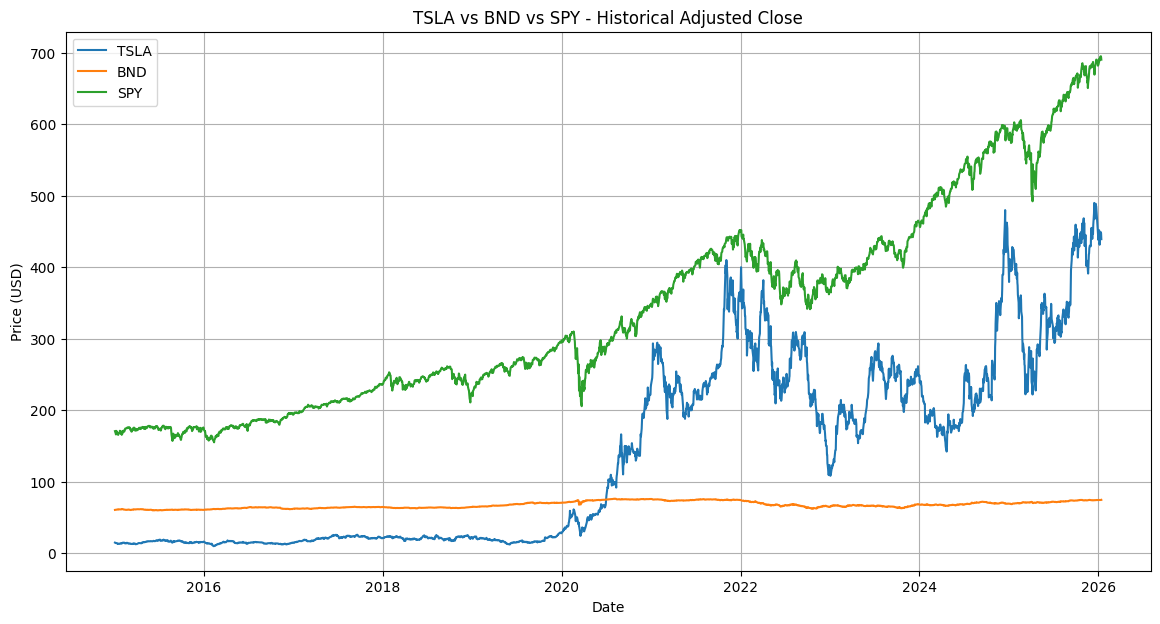

In [4]:
plot_closing_prices(adj_close_df, title="TSLA vs BND vs SPY - Historical Adjusted Close")

### 5.2 Daily Returns & Volatility
Calculating daily percentage changes to observe volatility clusters.

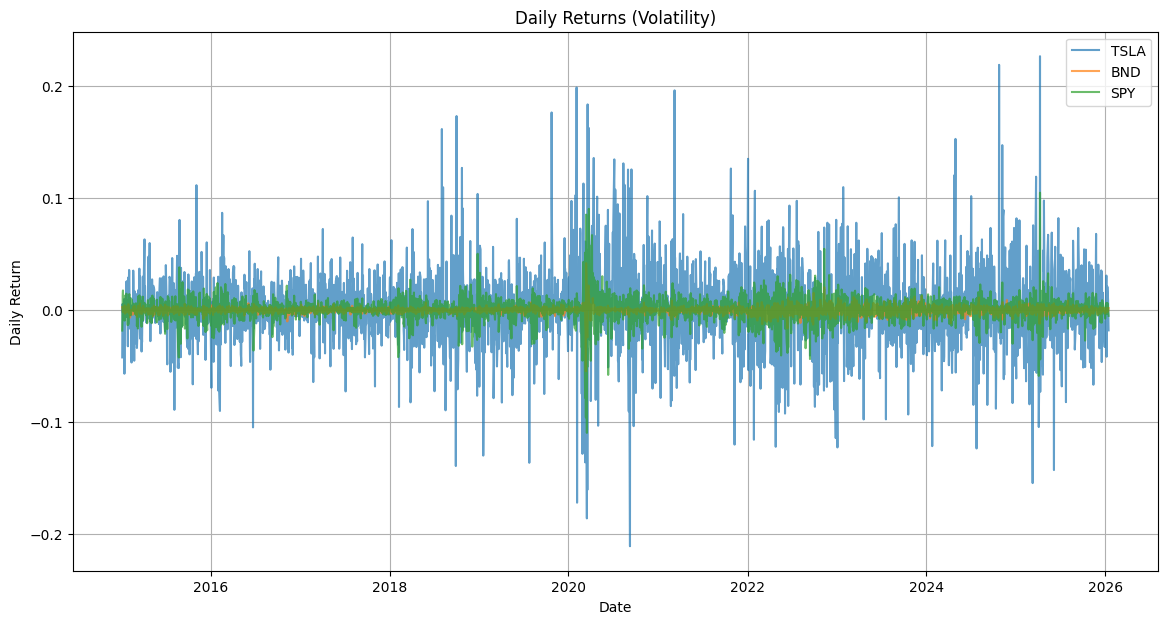

In [5]:
daily_returns = calculate_returns(adj_close_df)
plot_daily_returns(daily_returns)

### 5.3 Rolling Volatility (Standard Deviation)
We use a 30-day rolling window to visualize how risk changes over time.

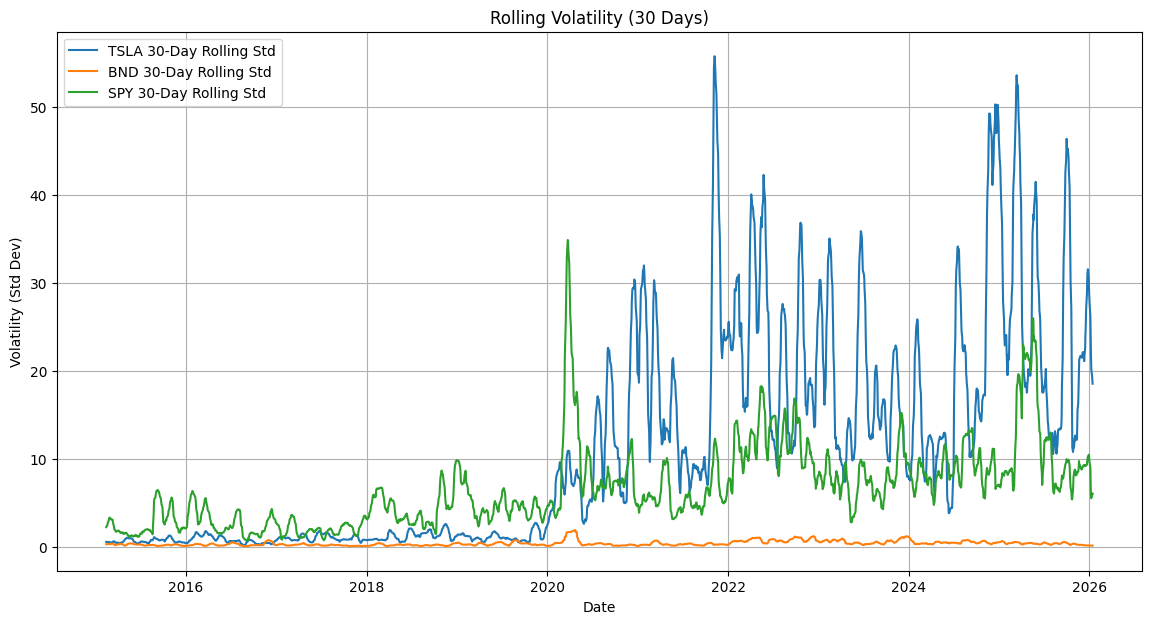

In [6]:
plot_rolling_stats(adj_close_df, window=30)

### 5.4 Outlier Detection in Daily Returns (New!)

We compute daily returns and formally flag extreme observations using two robust methods:

* **Z-score > |4|**: Identifies very extreme moves, typically more than $\pm 4\sigma$ from the mean.
* **IQR Method (Multiplier = 3)**: Catches values beyond $3 \times$ the interquartile range (extreme outliers).

In [11]:
print("### 5.4 Outlier Detection in Daily Returns")

def detect_outliers(returns_series, method='zscore', threshold=4.0):
    returns_series = returns_series.dropna()
    if method == 'zscore':
        z = np.abs(stats.zscore(returns_series))
        outliers = returns_series[z > threshold]
    elif method == 'iqr':
        Q1 = returns_series.quantile(0.25)
        Q3 = returns_series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        outliers = returns_series[(returns_series < lower) | (returns_series > upper)]
    else:
        raise ValueError("Method must be 'zscore' or 'iqr'")
    
    return outliers.sort_values(ascending=False)  # sorted by magnitude

# Apply to each ticker
print("\nOutliers using Z-score > |4| (very extreme moves):")
for ticker in daily_returns.columns:
    outs = detect_outliers(daily_returns[ticker], method='zscore', threshold=4.0)
    print(f"\n{ticker} - {len(outs)} outliers found")
    if not outs.empty:
        print("Top 10 largest (by absolute value):")
        print(outs.head(10))
        print("... (showing only top 10)")
    else:
        print("No extreme outliers detected at this threshold.")

print("\nExtreme Outliers using IQR (multiplier = 3):")
for ticker in daily_returns.columns:
    outs = detect_outliers(daily_returns[ticker], method='iqr', threshold=3.0)
    print(f"\n{ticker} - {len(outs)} outliers found")
    if not outs.empty:
        print("Top 10 largest:")
        print(outs.head(10))
        print("...")

# Optional: Summary table of outlier counts
outlier_summary = pd.DataFrame({
    'Ticker': daily_returns.columns,
    'Z-score > |4| Count': [len(detect_outliers(daily_returns[t], 'zscore', 4.0)) for t in daily_returns.columns],
    'IQR (x3) Count': [len(detect_outliers(daily_returns[t], 'iqr', 3.0)) for t in daily_returns.columns]
})
print("\nOutlier Detection Summary:")
print(outlier_summary)

### 5.4 Outlier Detection in Daily Returns

Outliers using Z-score > |4| (very extreme moves):

TSLA - 16 outliers found
Top 10 largest (by absolute value):
Date
2025-04-09    0.226900
2024-10-24    0.219190
2020-02-03    0.198949
2021-03-09    0.196412
2020-03-19    0.183877
2019-10-24    0.176692
2018-10-01    0.173471
2020-03-24    0.162817
2018-08-02    0.161880
2024-04-29    0.153069
Name: TSLA, dtype: float64
... (showing only top 10)

BND - 11 outliers found
Top 10 largest (by absolute value):
Date
2020-03-13    0.042201
2020-03-23    0.022149
2022-11-10    0.020703
2020-03-20    0.016956
2022-09-28    0.015544
2020-03-10   -0.013444
2022-06-13   -0.016153
2020-03-11   -0.018941
2020-03-17   -0.020686
2020-03-18   -0.024140
Name: BND, dtype: float64
... (showing only top 10)

SPY - 19 outliers found
Top 10 largest (by absolute value):
Date
2025-04-09    0.105019
2020-03-24    0.090603
2020-03-13    0.085486
2020-04-06    0.067166
2020-03-26    0.058390
2022-11-10    0.054954
202

## 6. Time Series Decomposition
Decomposing **TSLA** into Trend, Seasonality, and Residuals to understand underlying patterns.

Decomposing TSLA Data...


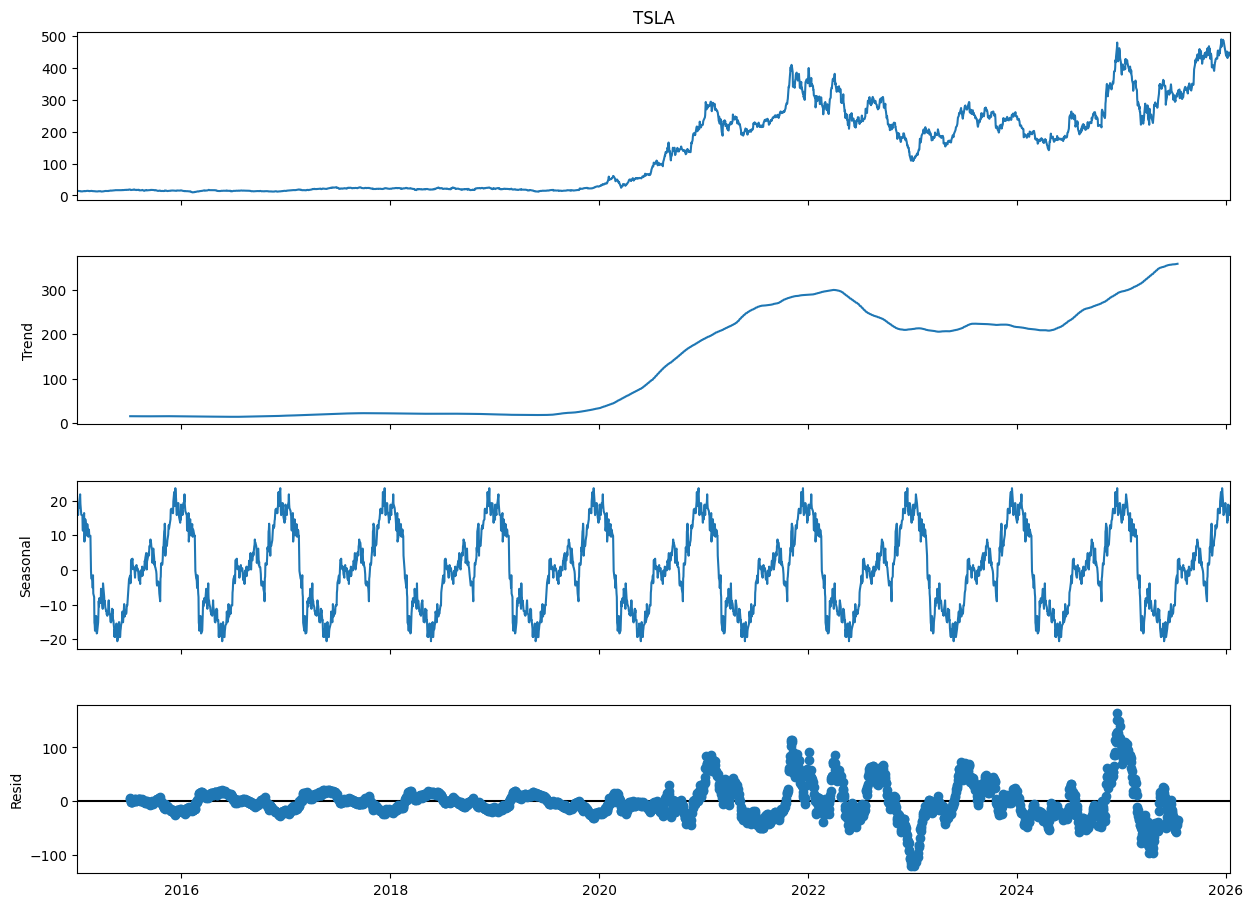

In [7]:
print("Decomposing TSLA Data...")
# We use 'additive' model here since the random data might not scale multiplicatively like real stocks
decompose_series(adj_close_df['TSLA'], model='additive', period=252)

# 7. Stationarity Test (Augmented Dickey-Fuller)
- ARIMA models require stationary data (constant mean and variance).
- We test both the Closing Price (usually non-stationary) and Returns (usually stationary).

In [8]:
print(">>> TEST 1: TSLA Raw Prices (Level)")
check_stationarity(adj_close_df['TSLA'], name="TSLA Closing Price")

print("\n>>> TEST 2: TSLA Daily Returns (Differenced)")
check_stationarity(daily_returns['TSLA'], name="TSLA Daily Returns")

>>> TEST 1: TSLA Raw Prices (Level)

--- Augmented Dickey-Fuller Test: TSLA Closing Price ---
ADF Statistic : -0.7801569882105649
p-value : 0.8248814297221108
#Lags Used : 28
Number of Observations Used : 2746
Result: Weak evidence against null hypothesis, time series has a unit root, indicating it is NON-STATIONARY.

>>> TEST 2: TSLA Daily Returns (Differenced)

--- Augmented Dickey-Fuller Test: TSLA Daily Returns ---
ADF Statistic : -53.0196185442436
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 2773
Result: Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is STATIONARY.


# 8. Risk Analysis (VaR & Sharpe Ratio)
Quantifying risk helps in portfolio optimization.
- VaR (Value at Risk): Max expected loss at 95% confidence.
- Sharpe Ratio: Risk-adjusted return.


In [9]:
risk_metrics = calculate_risk_metrics(daily_returns)
print("Risk Metrics Summary:")
display(risk_metrics)

Risk Metrics Summary:


,VaR_95,Sharpe_Ratio,Annualized_Sharpe
TSLA,-0.052529,0.049672,0.788518
BND,-0.004796,0.000510,0.008097
SPY,-0.016719,0.043556,0.691427


# 9. Save Data for Task 2

In [10]:
# Saving the processed data to CSV for the forecasting notebook.

output_path = '../data/processed/cleaned_adj_close.csv'
adj_close_df.to_csv(output_path)
print(f"Data saved to {output_path}")

Data saved to ../data/processed/cleaned_adj_close.csv


## Conclusion
*   **Trend Analysis:** TSLA shows an explosive exponential trend, starting around $14 in 2015 and peaking over $400. In contrast, BND remained highly stable, acting as a volatility dampener.
*   **Volatility:** TSLA has the highest volatility (Standard Deviation), with massive spikes in daily returns (up to ±20%) particularly around 2020/2021. SPY is moderate, while BND is nearly flat.
*   **Risk Metrics:** TSLA has a high VaR (-5.2%), meaning in a worst-case scenario (95% confidence), it could lose 5.2% in a single day. BND is much safer with a VaR of only -0.48%.
*   **Data Quality Note:** The API returned 'Close' prices which were already adjusted for splits/dividends (`auto_adjust=True`), so we used the 'Close' column as our Adjusted Close.